# 数据挖掘互评作业四：离群点分析与异常检测

## 学院：计算机学院&emsp;学号：3120191079&emsp;姓名：周泳宇

# wine数据集

# 一、算法介绍与引入

## 使用PyOD来做离群点检测，使用的是离群得分，即每个模型都会给每个数据点打分而非直接根据一个阈值判定某个点是否为离群点。

### 定义一个数组来保存下述所有的算法分类器

In [1]:
clfs = []

## 1.1 Angle_Based Outlier Detection (ABOD)
### 它考虑了每个数据点和其邻居的关系，但是不考虑邻居之间的关系。ABOD在多维度数据上表现较好，PyOD提供了两种不同版本的ABOD，Fast ABOD：使用KNN来近似，Original ABOD：以高时间复杂度来考虑所有训练数据点，这里采用Original ABOD

In [2]:
from pyod.models.abod import ABOD
clf_ABOD = ABOD()
clfs.append(["ABOD", clf_ABOD])

## 1.2 KNN 检测器
### 对于任意数据点，其到第k个邻居的距离可以作为其离群得分，PyOD提供三种不同的KNN检测器：Largest： 使用第k个邻居的距离来作为离群得分；Mean: 使用全部k个邻居的平均距离作为离群得分；Median:使用k个邻居的距离的中位数作为离群得分。这里采用Largest检测器。

In [1]:
from pyod.models.knn import KNN
clf_KNN = KNN()
clfs.append(["KNN", clf_KNN])

NameError: name 'clfs' is not defined

## 1.3 Isolation Forest
### 内部使用sklearn，此方法中，使用一个集合的树来完成数据分区。Isolation Forest提供一个离群得分来判定一个数据点在结构中有多孤立。其离群得分用来将它与正常观测数据区分开来。Isolation Forest在多维数据上表现很好

In [4]:
from pyod.models.iforest import IForest
clf_IForest = IForest()
clfs.append(["IForest", clf_IForest])

## 1.4 Histogram-based Outiler Detection
### 一种高效的无监督方法，它假设特征之间独立，然后通过构建直方图来计算离群得分，比多变量方法快得多，但是要损失一些精度

In [5]:
from pyod.models.hbos import HBOS
clf_HBOS = HBOS()
clfs.append(["HBOS", clf_HBOS])

## 1.5 Local Outlier Factor(LOF)
### LOF算法（Local Outlier Factor，局部离群因子检测方法），是一种无监督的离群检测方法，是基于密度的离群点检测方法中一个比较有代表性的算法。该算法会给数据集中的每个点计算一个离群因子LOF，通过判断LOF是否接近于1来判定是否是离群因子。若LOF远大于1，则认为是离群因子，接近于1，则是正常点

In [6]:
from pyod.models.lof import LOF
clf_LOF = LOF()
clfs.append(["LOF", clf_LOF])

## 1.6 Clustering Based Local Outiler Factor
### 它将数据分为小聚类簇和大聚类簇。离群得分基于数据点所属的聚类簇的大小来计算，距离计算方式为到最近大聚类簇的距离。

In [7]:
from pyod.models.cblof import CBLOF
clf_CBLOF = CBLOF()
clfs.append(["CBLOF", clf_CBLOF])

# 二、读入所有数据集并进行离群点分析与异常检测

## 思路如下：对于所有单个的benchmark，每次读入一个benchmark，然后进行训练集与测试集划分，并用上述6个检测算法进行训练与测试，记录在训练集与测试集上的评估指标（roc与prn），并记录下来，最后用表格进行展示（因benchmark太多，故这里不作图，只用表格展示）

## 2.1 首先展示对单个benchmark的处理

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('./wine/benchmarks/wine_benchmark_0001.csv')

In [4]:
df.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,wine_point_3594,wine,regression,7,0.050492,nominal,-1.245962,-0.362411,-0.265853,-0.261304,-0.343495,1.209882,0.747594,-0.899276,0.817846,-0.613338,0.174560
1,wine_point_5089,wine,regression,5,0.082237,anomaly,0.759540,0.973867,0.215849,-0.534540,0.598458,-0.536656,0.199134,0.968217,0.071518,0.596292,-0.915394
2,wine_point_1912,wine,regression,6,0.290201,nominal,-0.088942,-0.969809,-0.403482,-0.870829,-0.429127,-0.592996,-0.791633,-0.699187,-1.110168,1.402712,-0.496181
3,wine_point_4908,wine,regression,5,0.053559,anomaly,0.219597,0.973867,0.284664,0.138039,0.427194,-0.762016,-0.243173,1.034913,0.817846,1.805921,0.006874
4,wine_point_2246,wine,regression,7,0.420300,nominal,0.219597,-0.180191,-0.541112,0.348220,-0.714567,-0.142276,0.446826,-0.242318,-0.363840,-1.016548,0.090717


### 将是否离群转换为数字标签

In [5]:
label_mapping = {
           'nominal': 0,
           'anomaly': 1}
df['ground.truth'] = df['ground.truth'].map(label_mapping)

In [6]:
df.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,wine_point_3594,wine,regression,7,0.050492,0,-1.245962,-0.362411,-0.265853,-0.261304,-0.343495,1.209882,0.747594,-0.899276,0.817846,-0.613338,0.174560
1,wine_point_5089,wine,regression,5,0.082237,1,0.759540,0.973867,0.215849,-0.534540,0.598458,-0.536656,0.199134,0.968217,0.071518,0.596292,-0.915394
2,wine_point_1912,wine,regression,6,0.290201,0,-0.088942,-0.969809,-0.403482,-0.870829,-0.429127,-0.592996,-0.791633,-0.699187,-1.110168,1.402712,-0.496181
3,wine_point_4908,wine,regression,5,0.053559,1,0.219597,0.973867,0.284664,0.138039,0.427194,-0.762016,-0.243173,1.034913,0.817846,1.805921,0.006874
4,wine_point_2246,wine,regression,7,0.420300,0,0.219597,-0.180191,-0.541112,0.348220,-0.714567,-0.142276,0.446826,-0.242318,-0.363840,-1.016548,0.090717


### 提取训练属性与标签

In [7]:
col_n = ['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides', 'free.sulfur.dioxide', 
         'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'ground.truth']

data = pd.DataFrame(df,columns = col_n)

In [8]:
x = data.iloc[:, :-1]
y = data.iloc[:, -1:]

### 划分训练集（80%）与测试集（20%）

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### 将数据转换成np.array()并用分类器进行检测

In [10]:
import numpy as np

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [11]:
clf_name = 'KNN'
clf = KNN()
clf.fit(x_train)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [12]:
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(x_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(x_test)  # outlier scores

###  可视化离群点检测效果

In [13]:
from sklearn.manifold import TSNE
# T-SNE Implementation
X_train_reduced_tsne = TSNE(n_components=2, random_state=2020, init='pca', n_iter=2000).fit_transform(x_train)
X_test_reduced_tsne = TSNE(n_components=2, random_state=2020, init='pca', n_iter=2000).fit_transform(x_test)

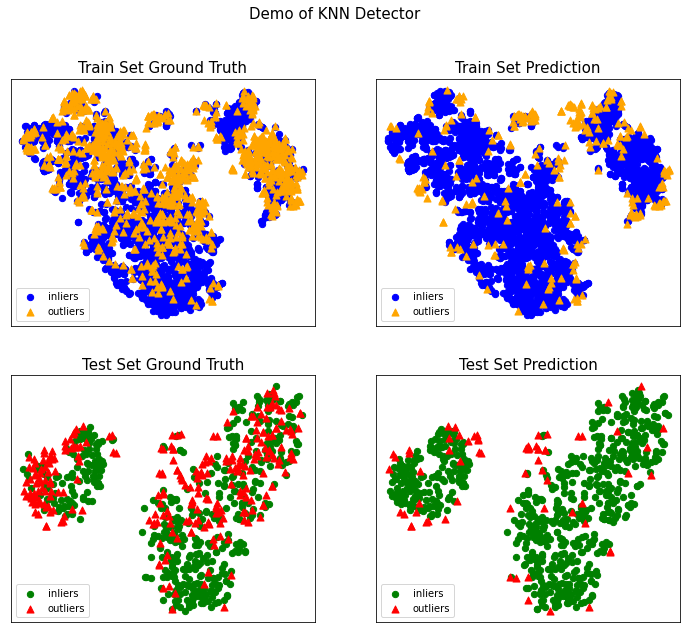

In [14]:
import warnings
warnings.filterwarnings("ignore")
from pyod.utils.example import visualize
visualize('KNN', X_train_reduced_tsne, y_train, X_test_reduced_tsne, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

### 用roc和prn评价准确率

In [21]:
from sklearn.metrics import roc_auc_score
from pyod.utils.utility import precision_n_scores

In [22]:
train_roc = np.round(roc_auc_score(y_train, y_train_pred), decimals=4)
train_prn = np.round(precision_n_scores(y_train, y_train_pred), decimals=4)
test_roc = np.round(roc_auc_score(y_test, y_test_pred), decimals=4)
test_prn = np.round(precision_n_scores(y_test, y_test_pred), decimals=4)

In [23]:
print(train_roc)
print(train_prn)
print(test_roc)
print(test_prn)

0.5243
0.4714
0.5325
0.5303


## 2.2 展示用多个算法对批量数据进行检测与评价（有些benchmark的训练集或测试集只有全为异常值或全为非异常值，无法用roc_auc_score进行评价，故设为0）

### 新建一个dict，用于保存结果

In [24]:
result = dict()

In [25]:
result = dict()
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from pyod.utils.utility import precision_n_scores
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

files = os.listdir('./wine/benchmarks')
# files[315:330]
for file in tqdm(files):
#     print(file)
    df = pd.read_csv('./wine/benchmarks/' + file)
    
    label_mapping = {
           'nominal': 0,
           'anomaly': 1}
    df['ground.truth'] = df['ground.truth'].map(label_mapping)
    
    col_n = ['fixed.acidity', 'volatile.acidity', 'citric.acid', 'residual.sugar', 'chlorides', 'free.sulfur.dioxide', 
         'total.sulfur.dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'ground.truth']
    data = pd.DataFrame(df,columns = col_n)
    
    x = data.iloc[:, :-1]
    y = data.iloc[:, -1:]
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    for clf_item in clfs:
#         print(clf_item)
        clf_name = clf_item[0]
        clf = clf_item[1]
        clf.fit(x_train)
        
        y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
        y_train_scores = clf.decision_scores_  # raw outlier scores

        # get the prediction on the test data
        y_test_pred = clf.predict(x_test)  # outlier labels (0 or 1)
        y_test_scores = clf.decision_function(x_test)  # outlier scores
        
        try:
            train_roc = np.round(roc_auc_score(y_train, y_train_pred), decimals=4)
        except:
            train_roc = 0.0
#         train_roc = np.round(roc_auc_score(y_train, y_train_scores), decimals=4)
        train_prn = np.round(precision_n_scores(y_train, y_train_pred), decimals=4)
        try:
            test_roc = np.round(roc_auc_score(y_test, y_test_pred), decimals=4)
        except:
            test_roc = 0.0
#         test_roc = np.round(roc_auc_score(y_test, y_test_scores), decimals=4)
        test_prn = np.round(precision_n_scores(y_test, y_test_pred), decimals=4)
        
        try:
            result[file]
            result[file][clf_name] = [train_roc, train_prn, test_roc, test_prn]
        except:
            result[file] = {}
            result[file][clf_name] = [train_roc, train_prn, test_roc, test_prn]

100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [58:27<00:00,  2.90s/it]


In [26]:
result_df = pd.DataFrame(columns=['benchmark', 'clf_name', 'train_roc', 'train_prn', 'test_roc', 'test_prn'])

for benchmark in tqdm(result):
    for clf_name in result[benchmark]:
        values = result[benchmark][clf_name]
        train_roc = values[0]
        train_prn = values[1]
        test_roc = values[2]
        test_prn = values[3]
        
        c = {"benchmark": benchmark, "clf_name": clf_name, "train_roc": train_roc, 
             "train_prn": train_prn, "test_roc": test_roc, "test_prn": test_prn}
#         print(c)

        insertRow = pd.DataFrame(c, columns=['benchmark', 'clf_name', 'train_roc', 'train_prn', 'test_roc', 'test_prn'],index = [0])
#         print(insertRow)

        result_df = result_df.append(insertRow)
        

100%|██████████████████████████████████████████████████████████████████████████████| 1210/1210 [00:29<00:00, 41.39it/s]


## 2.3 结果如下表所示，详细结果见附件：wine_result.csv

In [27]:
result_df

,benchmark,clf_name,train_roc,train_prn,test_roc,test_prn
0,wine_benchmark_0001.csv,ABOD,0.5000,0.0000,0.5000,0.0000
0,wine_benchmark_0001.csv,KNN,0.5243,0.4714,0.5325,0.5303
0,wine_benchmark_0001.csv,IForest,0.5228,0.4646,0.5195,0.4571
0,wine_benchmark_0001.csv,HBOS,0.5221,0.4613,0.5009,0.3662
0,wine_benchmark_0001.csv,LOF,0.5191,0.4478,0.5248,0.4923
...,...,...,...,...,...,...
0,wine_benchmark_1680.csv,KNN,0.5310,0.1597,0.5222,0.1304
0,wine_benchmark_1680.csv,IForest,0.5137,0.1278,0.5122,0.0000
0,wine_benchmark_1680.csv,HBOS,0.5102,0.1214,0.4979,0.0857
0,wine_benchmark_1680.csv,LOF,0.5275,0.1534,0.5265,0.0000


In [28]:
result_df.to_csv('./wine_result.csv', index=None)

## 2.4 分析：可以看到针对不同的数据集，不同的算法各有优劣。因此，在实际使用过程中，需要针对具体的场景，选择合适的异常点检测算法。

# 三、总结
## 1.LOF类的算法适用于局部区域空间问题，对于完整区域空间，KNN和Iforest更好。

## 2.KNN每次运行需要遍历所有数据，所以效率比较低，如果效率要求比较高，用聚类方法更好。

## 3.传统机器学习算法中Iforest、KNN表现较好。

## 4.对于不同种类的数据，没有哪一种算法是最好的，HBOS算法在某些数据集上的表现非常好，且运算速度很快。

## 5.当数据特征数很多时，只有KNN表现还不错，Iforest表现也不好，因为特征选取的随机性，可能无法覆盖足够多的特征（不绝对）。

## 6.ABOD综合效果最差，尽量不要用。